In [1]:
from sklearn import preprocessing
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as mp
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from imblearn.over_sampling import SMOTE
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sentence_transformers import SentenceTransformer
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from scipy.stats import randint
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold

## Loading data

In [2]:
data = 'training.xlsx'
dtrain = pd.read_excel(data)
dtrain.head()

,input,output
0,px2+px+k=0 \n7((-5)2-5)+k=0\n 7(25-5)+k=0\n140...,0.0
1,X= - b ± √b2 – 4ac/2a\t\nx= - 3 ± √(3)2 -4(4)...,0.0
2,x2 + kx + 64=0 \nx - 8x +k =0 \nb - 4ac>= 0\n ...,0.0
3,"""X=- b ± squareroot(b^2-4ac) /2a\n X= - (-2√2)...",0.0
4,X= -(-2√2)±√((2√2)^2+4(√(3 ))(2√3) )\n\n=2√2±√...,0.0


## Data Preprocessing

In [3]:
#removing line breaks and converting to str
def remove(s):
    if isinstance(s, str):
        return ' '.join(s.splitlines())
    else:
        return s

dtrain['input'] = dtrain['input'].apply(remove)
dtrain.head()

,input,output
0,px2+px+k=0 7((-5)2-5)+k=0 7(25-5)+k=0 140+k=...,0.0
1,X= - b ± √b2 – 4ac/2a\t x= - 3 ± √(3)2 -4(4)5...,0.0
2,x2 + kx + 64=0 x - 8x +k =0 b - 4ac>= 0 k2-...,0.0
3,"""X=- b ± squareroot(b^2-4ac) /2a X= - (-2√2) ...",0.0
4,X= -(-2√2)±√((2√2)^2+4(√(3 ))(2√3) ) =2√2±√(8...,0.0


## Class labelling
0-3 incorrect

3-4 partially correct

4-5 correct

In [4]:
def classes(marks):
    if (0<=marks<3):
        return 'incorrect'
    elif (3<=marks<4):
        return 'partially correct'
    elif (4<=marks<=5):
        return 'correct'

dtrain['class'] = dtrain['output'].apply(classes)
dtrain.head()

,input,output,class
0,px2+px+k=0 7((-5)2-5)+k=0 7(25-5)+k=0 140+k=...,0.0,incorrect
1,X= - b ± √b2 – 4ac/2a\t x= - 3 ± √(3)2 -4(4)5...,0.0,incorrect
2,x2 + kx + 64=0 x - 8x +k =0 b - 4ac>= 0 k2-...,0.0,incorrect
3,"""X=- b ± squareroot(b^2-4ac) /2a X= - (-2√2) ...",0.0,incorrect
4,X= -(-2√2)±√((2√2)^2+4(√(3 ))(2√3) ) =2√2±√(8...,0.0,incorrect


In [5]:
numeric = dtrain.copy()
#Label encoding: 
# 0 = incorrect
# 1 = partially correct
# 2 = correct

def labelencode(x):
    if(x=='incorrect'):
        return 0
    elif(x=='partially correct'):
        return 1
    if(x=='correct'):
        return 2

numeric['class'] = numeric['class'].apply(labelencode)
numeric.head()

,input,output,class
0,px2+px+k=0 7((-5)2-5)+k=0 7(25-5)+k=0 140+k=...,0.0,0
1,X= - b ± √b2 – 4ac/2a\t x= - 3 ± √(3)2 -4(4)5...,0.0,0
2,x2 + kx + 64=0 x - 8x +k =0 b - 4ac>= 0 k2-...,0.0,0
3,"""X=- b ± squareroot(b^2-4ac) /2a X= - (-2√2) ...",0.0,0
4,X= -(-2√2)±√((2√2)^2+4(√(3 ))(2√3) ) =2√2±√(8...,0.0,0


### Number of samples in each class:

In [6]:
print("The number of samples for class 0 (incorrect) = ", len(numeric[numeric['class']==0]))
print("The number of samples for class 1 (partially correct) = ", len(numeric[numeric['class']==1]))
print("The number of samples for class 2 (correct) = ", len(numeric[numeric['class']==2]))

The number of samples for class 0 (incorrect) =  483
The number of samples for class 1 (partially correct) =  317
The number of samples for class 2 (correct) =  327


# Vectorization

## RoBERTa

In [7]:
model_roberta = SentenceTransformer('sentence-transformers/msmarco-roberta-base-v2')
roberta_train = numeric.copy()
roberta_train['EmbeddingsLM']=roberta_train['input'].apply(lambda x:model_roberta.encode(str(x)))

#stripping spaces in embeddings
roberta_train['Embeddings_converted'] = roberta_train['EmbeddingsLM'].apply(lambda x: x.tolist())
num_columns = len(roberta_train['Embeddings_converted'][0]) 

for i in range(num_columns):
    col_name = "Embedding_"+str(i)
    roberta_train[col_name] = roberta_train['Embeddings_converted'].apply(lambda x: x[i])

roberta_train.head()

,input,output,class,EmbeddingsLM,Embeddings_converted,Embedding_0,Embedding_1,Embedding_2,Embedding_3,Embedding_4,...,Embedding_758,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767
0,px2+px+k=0 7((-5)2-5)+k=0 7(25-5)+k=0 140+k=...,0.0,0,"[0.28532258, -0.057623234, -0.34162292, -0.131...","[0.2853225767612457, -0.057623233646154404, -0...",0.285323,-0.057623,-0.341623,-0.131081,-1.339097,...,-0.053912,0.411850,0.141088,0.390931,0.005773,-0.441898,0.412513,0.808557,-0.009286,0.281078
1,X= - b ± √b2 – 4ac/2a\t x= - 3 ± √(3)2 -4(4)5...,0.0,0,"[0.16487539, -0.10933262, -0.44213882, -0.1086...","[0.16487538814544678, -0.1093326210975647, -0....",0.164875,-0.109333,-0.442139,-0.108664,-0.830387,...,0.014154,-0.000657,-0.320697,-0.016497,-0.143669,-0.166758,0.398254,0.418296,0.181428,0.140939
2,x2 + kx + 64=0 x - 8x +k =0 b - 4ac>= 0 k2-...,0.0,0,"[0.07860213, -0.13562588, -0.37460077, 0.07451...","[0.0786021277308464, -0.13562588393688202, -0....",0.078602,-0.135626,-0.374601,0.074517,-0.984489,...,0.143810,0.420218,-0.330064,0.046220,0.267782,-0.329266,-0.484847,0.321706,-0.195739,0.022827
3,"""X=- b ± squareroot(b^2-4ac) /2a X= - (-2√2) ...",0.0,0,"[0.37452427, -0.5105569, -0.5121521, 0.4097589...","[0.3745242655277252, -0.5105568766593933, -0.5...",0.374524,-0.510557,-0.512152,0.409759,-0.693743,...,-0.003171,0.378099,-0.967900,0.105310,-0.179794,-0.077763,0.194810,0.224533,0.823339,0.303765
4,X= -(-2√2)±√((2√2)^2+4(√(3 ))(2√3) ) =2√2±√(8...,0.0,0,"[0.24716118, -0.38430008, -0.07663244, 0.13919...","[0.24716117978096008, -0.3843000829219818, -0....",0.247161,-0.384300,-0.076632,0.139193,-0.417148,...,-0.243447,0.386594,-0.298049,0.052747,0.099612,-0.273706,-0.104422,0.688664,0.197059,0.180008


In [8]:
roberta_train.drop(['input','output','class','EmbeddingsLM','Embeddings_converted'], axis=1, inplace=True)
roberta_train.head()

,Embedding_0,Embedding_1,Embedding_2,Embedding_3,Embedding_4,Embedding_5,Embedding_6,Embedding_7,Embedding_8,Embedding_9,...,Embedding_758,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767
0,0.285323,-0.057623,-0.341623,-0.131081,-1.339097,0.159932,0.053932,-0.639942,0.092896,0.331048,...,-0.053912,0.411850,0.141088,0.390931,0.005773,-0.441898,0.412513,0.808557,-0.009286,0.281078
1,0.164875,-0.109333,-0.442139,-0.108664,-0.830387,0.926930,-0.063360,-0.391000,0.167125,0.242181,...,0.014154,-0.000657,-0.320697,-0.016497,-0.143669,-0.166758,0.398254,0.418296,0.181428,0.140939
2,0.078602,-0.135626,-0.374601,0.074517,-0.984489,-0.025779,-0.008605,-0.653329,0.005801,0.275466,...,0.143810,0.420218,-0.330064,0.046220,0.267782,-0.329266,-0.484847,0.321706,-0.195739,0.022827
3,0.374524,-0.510557,-0.512152,0.409759,-0.693743,-0.333489,0.479846,-0.124172,0.172762,0.988780,...,-0.003171,0.378099,-0.967900,0.105310,-0.179794,-0.077763,0.194810,0.224533,0.823339,0.303765
4,0.247161,-0.384300,-0.076632,0.139193,-0.417148,0.175644,0.130327,-0.220217,-0.003852,0.570962,...,-0.243447,0.386594,-0.298049,0.052747,0.099612,-0.273706,-0.104422,0.688664,0.197059,0.180008


In [9]:
roberta_train['class'] = numeric['class']
roberta_train.head()
roberta_train.to_excel('roberta_train.xlsx', index=False)

In [14]:
roberta_train  = pd.read_excel('roberta_train.xlsx')
X = roberta_train.iloc[0:, 0:-1]
X = pd.DataFrame(X)
X.head()

,Embedding_0,Embedding_1,Embedding_2,Embedding_3,Embedding_4,Embedding_5,Embedding_6,Embedding_7,Embedding_8,Embedding_9,...,Embedding_758,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767
0,0.285323,-0.057623,-0.341623,-0.131081,-1.339097,0.159932,0.053932,-0.639942,0.092896,0.331048,...,-0.053912,0.411850,0.141088,0.390931,0.005773,-0.441898,0.412513,0.808557,-0.009286,0.281078
1,0.164875,-0.109333,-0.442139,-0.108664,-0.830387,0.926930,-0.063360,-0.391000,0.167125,0.242181,...,0.014154,-0.000657,-0.320697,-0.016497,-0.143669,-0.166758,0.398254,0.418296,0.181428,0.140939
2,0.078602,-0.135626,-0.374601,0.074517,-0.984489,-0.025779,-0.008605,-0.653329,0.005801,0.275466,...,0.143810,0.420218,-0.330064,0.046220,0.267782,-0.329266,-0.484847,0.321706,-0.195739,0.022827
3,0.374524,-0.510557,-0.512152,0.409759,-0.693743,-0.333489,0.479846,-0.124172,0.172762,0.988780,...,-0.003171,0.378099,-0.967900,0.105310,-0.179794,-0.077763,0.194810,0.224533,0.823339,0.303765
4,0.247161,-0.384300,-0.076632,0.139193,-0.417148,0.175644,0.130327,-0.220217,-0.003852,0.570962,...,-0.243447,0.386594,-0.298049,0.052747,0.099612,-0.273706,-0.104422,0.688664,0.197059,0.180008


In [15]:
Y = roberta_train.iloc[0:, -1]
Y = pd.DataFrame(Y)
Y.head()

,class
0,0
1,0
2,0
3,0
4,0


### Train-Test Split

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

# PRINCIPAL COMPONENT ANALYSIS

In [18]:
# PCA new code
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
 
# Apply standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
 
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
 
# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
 
# Determine the number of components needed to explain at least 0.98 (98%) variance
n_components = np.argmax(cumulative_explained_variance >= 0.98)
print("Number of components explaining 98% variance:", n_components)

# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
 
# Create a DataFrame
X_pca = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])
 
# Print the transformed data
X_pca.head()

Number of components explaining 98% variance: 212


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC203,PC204,PC205,PC206,PC207,PC208,PC209,PC210,PC211,PC212
0,6.673308,-4.241923,3.283099,-1.495571,-2.098529,-5.307566,-6.553748,-0.632332,2.264172,-7.211979,...,0.560241,-0.051007,0.388531,0.289798,-0.390276,-0.126534,0.285082,-0.386580,-0.423887,0.849997
1,-1.756011,-9.155181,0.069293,-0.730151,-5.470468,10.489080,3.618232,-7.305323,4.945810,-1.459128,...,0.402060,-0.051492,0.352908,0.166560,-0.030421,0.265364,0.200152,-0.031475,0.186652,0.129005
2,5.034252,-7.458419,-3.080619,-0.365320,1.638180,-0.690383,-5.579857,-1.893463,4.879537,-7.878183,...,-0.269275,0.353596,-0.403954,-0.601600,-0.414618,-0.032295,-0.023921,0.077409,0.072410,-0.471429
3,-6.564388,-0.926613,13.882278,-0.768214,11.489165,7.404212,2.231978,-1.230142,4.627857,-2.802418,...,-0.172369,-0.364446,-0.827148,0.169848,-0.274505,-0.325730,-0.478324,-0.047747,0.673774,-0.292911
4,1.559586,-5.219869,1.829680,6.576387,-0.553869,8.172490,-7.482649,-4.178704,5.616555,-3.057285,...,-0.693610,0.361159,0.121710,0.254962,0.054792,-0.011057,0.337615,-0.770718,0.324510,0.302915


In [19]:
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_pca, Y, test_size=0.3)
Y_train_pca = pd.DataFrame(Y_train_pca)
Y_test_pca = pd.DataFrame(Y_test_pca)
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

# TRADITIONAL MODELS

#### Cross Validation

In [7]:
def crossvalidation(model_name,X,Y):
    # Define the scoring metrics
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='weighted')
    }
    
    cv = KFold(n_splits=10, random_state=42, shuffle=True)

    # Perform cross-validation
    cv_results = cross_validate(model_name, X, Y, scoring=scoring, cv=cv, n_jobs=-1)
    
    # Extract and print results
    accuracy_mean = cv_results['test_accuracy'].mean()
    accuracy_std = cv_results['test_accuracy'].std()
    
    precision_mean = cv_results['test_precision'].mean()
    precision_std = cv_results['test_precision'].std()
    
    recall_mean = cv_results['test_recall'].mean()
    recall_std = cv_results['test_recall'].std()
    
    f1_score_mean = cv_results['test_f1_score'].mean()
    f1_score_std = cv_results['test_f1_score'].std()
    
    print('Accuracy: Mean -', accuracy_mean, ' Std -', accuracy_std)
    print('Precision: Mean -', precision_mean, ' Std -', precision_std)
    print('Recall: Mean -', recall_mean, ' Std -', recall_std)
    print('F1 Score: Mean -', f1_score_mean, ' Std -', f1_score_std)
    

# 1) KNN

In [40]:
model_knn = KNeighborsClassifier(n_neighbors=22 , weights='distance', algorithm='auto', leaf_size=1, p=2, metric='euclidean', metric_params=None, n_jobs=-1)
model_knn.fit(X_train, Y_train)
knn_predictions = model_knn.predict(X_test)
print('Accuracy score:', accuracy_score(Y_test, knn_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test, knn_predictions))
print('Classification Report:', classification_report(Y_test, knn_predictions))

Accuracy score: 0.49262536873156343
Confusion Matrix: [[91 30 23]
 [34 39 12]
 [23 50 37]]
Classification Report:               precision    recall  f1-score   support

           0       0.61      0.63      0.62       144
           1       0.33      0.46      0.38        85
           2       0.51      0.34      0.41       110

    accuracy                           0.49       339
   macro avg       0.49      0.48      0.47       339
weighted avg       0.51      0.49      0.49       339



## cross validation

In [41]:
crossvalidation(model_knn,X,Y)

Accuracy: Mean - 0.5394832490518332  Std - 0.05551874957200244
Precision: Mean - 0.5473766938314626  Std - 0.047823336025537656
Recall: Mean - 0.5394832490518332  Std - 0.05551874957200244
F1 Score: Mean - 0.537166715074442  Std - 0.05117006506870646


### After PCA

In [42]:
model_knn = KNeighborsClassifier(n_neighbors=22 , weights='distance', algorithm='auto', leaf_size=1, p=2, metric='euclidean', metric_params=None, n_jobs=-1)
model_knn.fit(X_train_pca, Y_train_pca)

knn_predictions = model_knn.predict(X_test_pca)
print('Accuracy score:', accuracy_score(Y_test_pca, knn_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test_pca, knn_predictions))
print('Classification Report:', classification_report(Y_test_pca, knn_predictions))

Accuracy score: 0.49852507374631266
Confusion Matrix: [[86 24 30]
 [37 31 35]
 [29 15 52]]
Classification Report:               precision    recall  f1-score   support

           0       0.57      0.61      0.59       140
           1       0.44      0.30      0.36       103
           2       0.44      0.54      0.49        96

    accuracy                           0.50       339
   macro avg       0.48      0.49      0.48       339
weighted avg       0.49      0.50      0.49       339



In [43]:
crossvalidation(model_knn,X_pca,Y)

Accuracy: Mean - 0.5420907079646018  Std - 0.05238566043886043
Precision: Mean - 0.5494951089798497  Std - 0.04638852103901188
Recall: Mean - 0.5420907079646018  Std - 0.05238566043886043
F1 Score: Mean - 0.53946305151871  Std - 0.04922317478137941


In [118]:
#NEW CODE FOR KNN HYPERPARAMETER TUNING
# Define the parameter grid to search
knn_params = {
    "n_neighbors": range(1, 20, 2),
    "weights" : ["uniform", "distance"],
    "metric" : ["euclidean", "manhattan"],
    "algorithm" : ["auto", "ball_tree", "kd_tree"],
    "leaf_size" : range(1, 30, 5)
}

# Create KNN model
knn = KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
knn_grid = GridSearchCV(estimator=knn, param_grid=knn_params, cv=cv, scoring='accuracy', n_jobs=-1, error_score=0)
knn_grid_results = knn_grid.fit(X_train_pca, Y_train_pca)

final_model_knn = knn.set_params(**knn_grid_results.best_params_)
final_model_knn.fit(X_train_pca, Y_train_pca)

knn_predictions = final_model_knn.predict(X_test_pca)
print('Accuracy score:', accuracy_score(Y_test_pca, knn_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test_pca, knn_predictions))
print('Classification Report:', classification_report(Y_test_pca, knn_predictions))
print('Best Parameters:', knn_grid_results.best_params_)

Accuracy score: 0.5575221238938053
Confusion Matrix: [[85 47 25]
 [19 49 25]
 [12 22 55]]
Classification Report:               precision    recall  f1-score   support

           0       0.73      0.54      0.62       157
           1       0.42      0.53      0.46        93
           2       0.52      0.62      0.57        89

    accuracy                           0.56       339
   macro avg       0.56      0.56      0.55       339
weighted avg       0.59      0.56      0.56       339

Best Parameters: {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'}


# 2) SVM Classifier

In [57]:
model_SVM = svm.SVC()
model_SVM.fit(X_train, Y_train)
support_vectors = model_SVM.support_vectors_
print("Number of support vectors:", len(support_vectors))
# print("Support vectors:\n", support_vectors)

svm_predictions = model_SVM.predict(X_test)
print('Accuracy score:', accuracy_score(Y_test, svm_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test, svm_predictions))
print('Classification Report:', classification_report(Y_test, svm_predictions))

Number of support vectors: 703
Accuracy score: 0.5073746312684366
Confusion Matrix: [[124   8  13]
 [ 60   9  37]
 [ 41   8  39]]
Classification Report:               precision    recall  f1-score   support

           0       0.55      0.86      0.67       145
           1       0.36      0.08      0.14       106
           2       0.44      0.44      0.44        88

    accuracy                           0.51       339
   macro avg       0.45      0.46      0.42       339
weighted avg       0.46      0.51      0.44       339



In [28]:
crossvalidation(model_SVM,X,Y)

Accuracy: Mean - 0.5367967762326169  Std - 0.0447089707967076
Precision: Mean - 0.52520237634022  Std - 0.048117106684915464
Recall: Mean - 0.5367967762326169  Std - 0.0447089707967076
F1 Score: Mean - 0.5090957838917369  Std - 0.045743209695174855


### After PCA

In [29]:
model_SVM = svm.SVC(C=0.1, degree=4, gamma='auto', kernel='poly')
model_SVM.fit(X_train_pca, Y_train_pca)
support_vectors = model_SVM.support_vectors_
print("Number of support vectors:", len(support_vectors))
# print("Support vectors:\n", support_vectors)

svm_predictions = model_SVM.predict(X_test_pca)
print('Accuracy score:', accuracy_score(Y_test_pca, svm_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test_pca, svm_predictions))
print('Classification Report:', classification_report(Y_test_pca, svm_predictions))

Number of support vectors: 714
Accuracy score: 0.56047197640118
Confusion Matrix: [[109  18  12]
 [ 38  30  30]
 [ 29  22  51]]
Classification Report:               precision    recall  f1-score   support

           0       0.62      0.78      0.69       139
           1       0.43      0.31      0.36        98
           2       0.55      0.50      0.52       102

    accuracy                           0.56       339
   macro avg       0.53      0.53      0.52       339
weighted avg       0.54      0.56      0.54       339



In [57]:
crossvalidation(model_SVM,X_pca,Y)

Accuracy: Mean - 0.5643410240202276  Std - 0.04005093332142952
Precision: Mean - 0.5625169396917556  Std - 0.03692614929173985
Recall: Mean - 0.5643410240202276  Std - 0.04005093332142952
F1 Score: Mean - 0.5578852233004541  Std - 0.03702440855518827


# 3) Decision Tree

Training Set Accuracy: 0.9263959390862944
Testing Set Accuracy: 0.41002949852507375
Tree Depth: 10


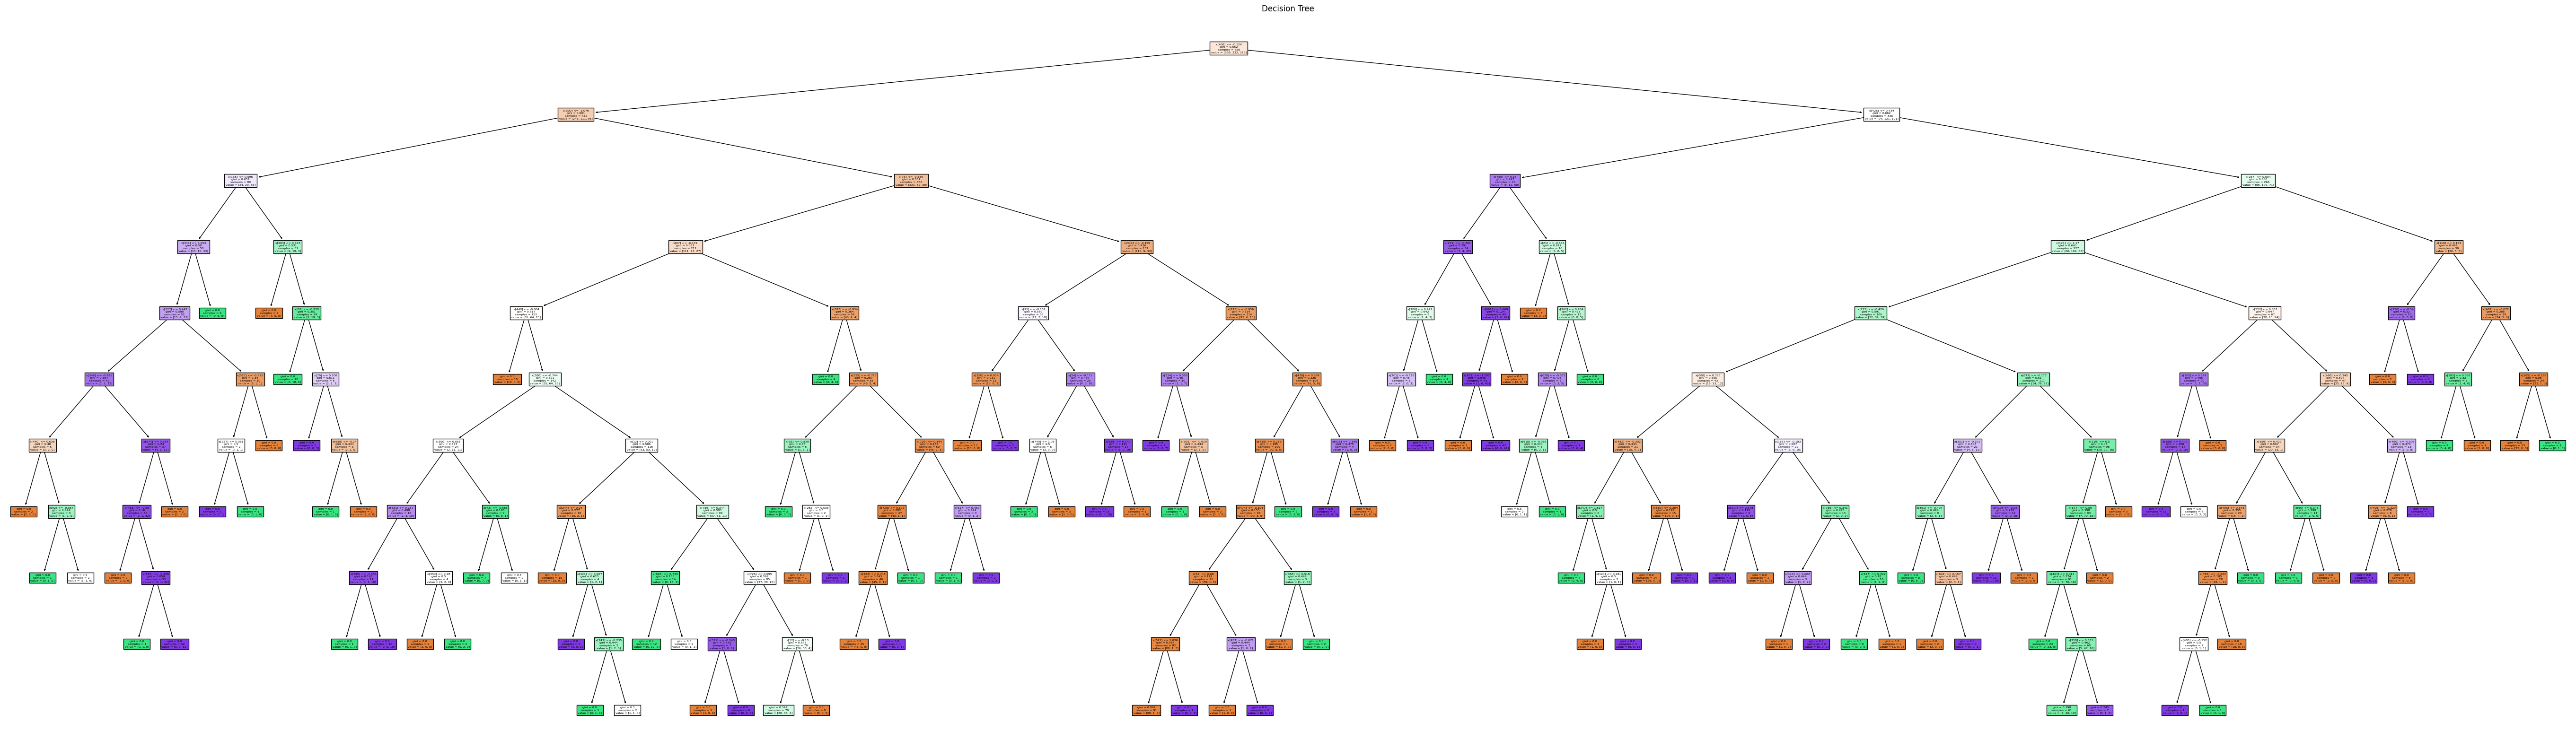

Accuracy score: 0.41002949852507375
Confusion Matrix: [[71 52 21]
 [26 37 22]
 [25 54 31]]
Classification Report:               precision    recall  f1-score   support

           0       0.58      0.49      0.53       144
           1       0.26      0.44      0.32        85
           2       0.42      0.28      0.34       110

    accuracy                           0.41       339
   macro avg       0.42      0.40      0.40       339
weighted avg       0.45      0.41      0.42       339



In [61]:
model_dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0)
model_dtree.fit(X_train , Y_train )
training_accuracy = model_dtree.score(X_train , Y_train )
testing_accuracy = model_dtree.score(X_test, Y_test)
print("Training Set Accuracy:", training_accuracy)
print("Testing Set Accuracy:", testing_accuracy)
tree_depth = model_dtree.get_depth()
print("Tree Depth:", tree_depth)

mp.figure(figsize=(70, 20))
plot_tree(model_dtree, filled=True)
mp.title("Decision Tree")
mp.show()
dt_predictions = model_dtree.predict(X_test)
print('Accuracy score:', accuracy_score(Y_test, dt_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test, dt_predictions))
print('Classification Report:', classification_report(Y_test, dt_predictions))

In [63]:
crossvalidation(model_dtree,X,Y)

Accuracy: Mean - 0.4543536662452592  Std - 0.042835246011845726
Precision: Mean - 0.4711608534559809  Std - 0.05471116207703494
Recall: Mean - 0.4543536662452592  Std - 0.042835246011845726
F1 Score: Mean - 0.4557326761318639  Std - 0.04672723301604494


### After PCA

Training Set Accuracy: 0.9606598984771574
Testing Set Accuracy: 0.41887905604719766
Tree Depth: 10


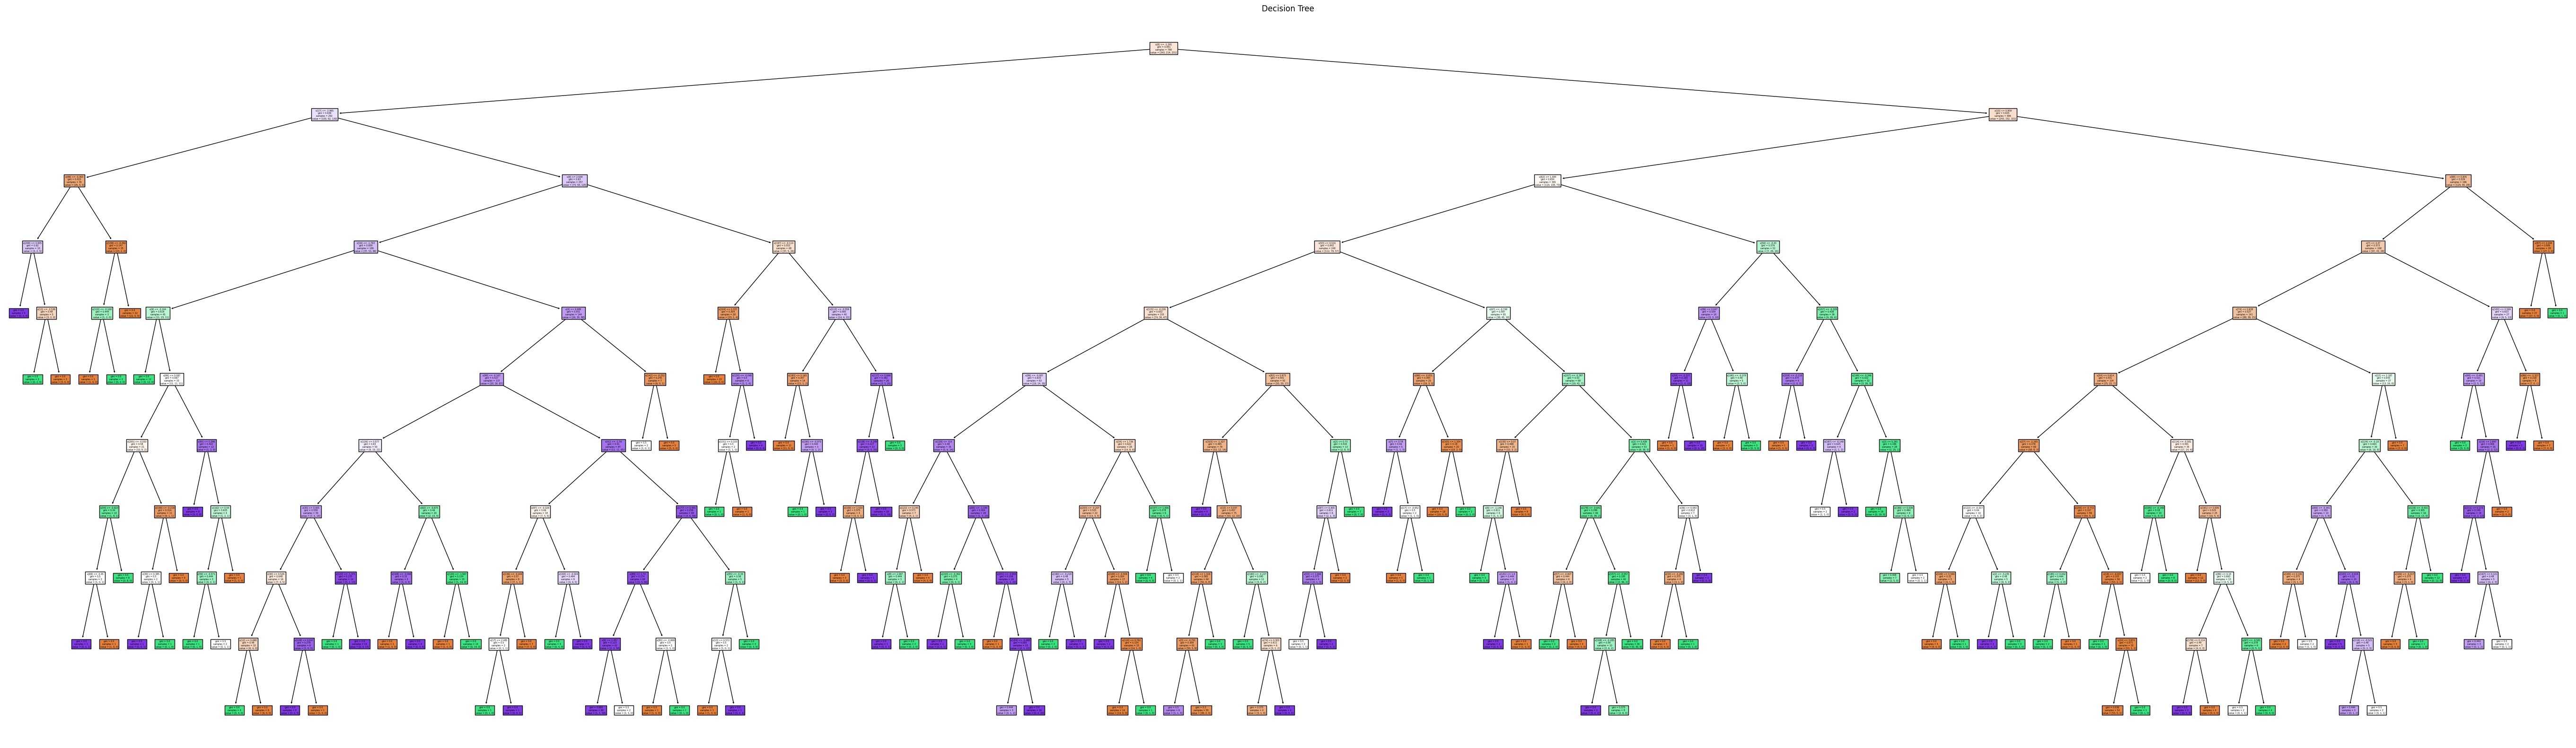

Accuracy score: 0.41887905604719766
Confusion Matrix: [[66 41 33]
 [36 35 32]
 [29 26 41]]
Classification Report:               precision    recall  f1-score   support

           0       0.50      0.47      0.49       140
           1       0.34      0.34      0.34       103
           2       0.39      0.43      0.41        96

    accuracy                           0.42       339
   macro avg       0.41      0.41      0.41       339
weighted avg       0.42      0.42      0.42       339



In [62]:
model_dtree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=10, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0)
model_dtree.fit(X_train_pca , Y_train_pca )
training_accuracy = model_dtree.score(X_train_pca , Y_train_pca )
testing_accuracy = model_dtree.score(X_test_pca, Y_test_pca)
print("Training Set Accuracy:", training_accuracy)
print("Testing Set Accuracy:", testing_accuracy)
tree_depth = model_dtree.get_depth()
print("Tree Depth:", tree_depth)

mp.figure(figsize=(70, 20))
plot_tree(model_dtree, filled=True)
mp.title("Decision Tree")
mp.show()
dt_predictions = model_dtree.predict(X_test_pca)
print('Accuracy score:', accuracy_score(Y_test_pca, dt_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test_pca, dt_predictions))
print('Classification Report:', classification_report(Y_test_pca, dt_predictions))

In [64]:
crossvalidation(model_dtree,X_pca,Y)

Accuracy: Mean - 0.44541719342604297  Std - 0.0240643153268458
Precision: Mean - 0.4488920607336815  Std - 0.024764787889433166
Recall: Mean - 0.44541719342604297  Std - 0.0240643153268458
F1 Score: Mean - 0.44389932909161534  Std - 0.02408280225252964


### Hyperparameter Tuning

In [ ]:
# Define the parameter grid to search
tree_params = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": range(1, 21),
    "min_samples_split": range(2, 11),
    "min_samples_leaf": range(1, 11),
    "max_features": ["auto", "sqrt", "log2", None]
}

decision_tree = DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
tree_grid = GridSearchCV(estimator=decision_tree, param_grid=tree_params, cv=cv, scoring='accuracy', n_jobs=-1, error_score=0)
tree_grid_results = tree_grid.fit(X_train, Y_train)

final_model_tree = decision_tree.set_params(**tree_grid_results.best_params_)
final_model_tree.fit(X_train, Y_train)

tree_predictions = final_model_tree.predict(X_test)
print('Accuracy score:', accuracy_score(Y_test, tree_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test, tree_predictions))
print('Classification Report:', classification_report(Y_test, tree_predictions))
print('Best Parameters:', tree_grid_results.best_params_)

# 4) Naive Bayes

In [67]:
model_NB = GaussianNB(var_smoothing = 1e-07) 
model_NB.fit(X_train, Y_train)
# Predict on the test set
nb_predictions = model_NB.predict(X_test)
print('Accuracy score of Naive Bayes classifier :', accuracy_score(Y_test, nb_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test, nb_predictions))
print('Classification Report:', classification_report(Y_test, nb_predictions))

Accuracy score of Naive Bayes classifier : 0.41887905604719766
Confusion Matrix: [[85 46 13]
 [37 30 18]
 [38 45 27]]
Classification Report:               precision    recall  f1-score   support

           0       0.53      0.59      0.56       144
           1       0.25      0.35      0.29        85
           2       0.47      0.25      0.32       110

    accuracy                           0.42       339
   macro avg       0.41      0.40      0.39       339
weighted avg       0.44      0.42      0.41       339



In [68]:
crossvalidation(model_NB,X,Y)

Accuracy: Mean - 0.4693189001264223  Std - 0.045489535670927506
Precision: Mean - 0.4697699800525269  Std - 0.05485251102733465
Recall: Mean - 0.4693189001264223  Std - 0.045489535670927506
F1 Score: Mean - 0.4572934865511364  Std - 0.05267582340389043


### After PCA

In [69]:
model_NB = GaussianNB(var_smoothing = 1e-07) 
model_NB.fit(X_train_pca, Y_train_pca)
# Predict on the test set
nb_predictions = model_NB.predict(X_test_pca)
print('Accuracy score of Naive Bayes classifier :', accuracy_score(Y_test_pca, nb_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test_pca, nb_predictions))
print('Classification Report:', classification_report(Y_test_pca, nb_predictions))

Accuracy score of Naive Bayes classifier : 0.4218289085545723
Confusion Matrix: [[58 34 48]
 [31 34 38]
 [29 16 51]]
Classification Report:               precision    recall  f1-score   support

           0       0.49      0.41      0.45       140
           1       0.40      0.33      0.36       103
           2       0.37      0.53      0.44        96

    accuracy                           0.42       339
   macro avg       0.42      0.43      0.42       339
weighted avg       0.43      0.42      0.42       339



In [70]:
crossvalidation(model_NB,X_pca,Y)

Accuracy: Mean - 0.45080594184576495  Std - 0.03608187492232018
Precision: Mean - 0.487470945481403  Std - 0.03623117452339753
Recall: Mean - 0.45080594184576495  Std - 0.03608187492232018
F1 Score: Mean - 0.45591774875619795  Std - 0.03369985496259826


# 5) ADA Boost

In [20]:
base_estimator = DecisionTreeClassifier(max_depth=1)
model_ada_boost = AdaBoostClassifier(learning_rate=0.1,n_estimators=100)

# Training the AdaBoost classifier
model_ada_boost.fit(X_train, Y_train)

# Making predictions on the test set
predictions_ada = model_ada_boost.predict(X_test)

# Calculating accuracy
print('Accuracy of AdaBoost classifier:', accuracy_score(Y_test, predictions_ada))
print('Confusion Matrix:', confusion_matrix(Y_test, predictions_ada))
print('Classification Report:', classification_report(Y_test, predictions_ada))

Accuracy of AdaBoost classifier: 0.4690265486725664
Confusion Matrix: [[112  14  19]
 [ 58  17  31]
 [ 42  16  30]]
Classification Report:               precision    recall  f1-score   support

           0       0.53      0.77      0.63       145
           1       0.36      0.16      0.22       106
           2       0.38      0.34      0.36        88

    accuracy                           0.47       339
   macro avg       0.42      0.42      0.40       339
weighted avg       0.44      0.47      0.43       339



In [21]:
crossvalidation(model_ada_boost,X,Y)

Accuracy: Mean - 0.5137721238938053  Std - 0.03136603391282208
Precision: Mean - 0.5097068455495475  Std - 0.05123017419551439
Recall: Mean - 0.5137721238938053  Std - 0.03136603391282208
F1 Score: Mean - 0.4875943673241885  Std - 0.029059584501459297


### After PCA

In [22]:
base_estimator = DecisionTreeClassifier(max_depth=1)
model_ada_boost = AdaBoostClassifier(learning_rate=0.1, base_estimator=base_estimator, n_estimators=100, random_state=42)

# Training the AdaBoost classifier
model_ada_boost.fit(X_train_pca, Y_train_pca)

# Making predictions on the test set
predictions_ada = model_ada_boost.predict(X_test_pca)

# Calculating accuracy
print('Accuracy of AdaBoost classifier:', accuracy_score(Y_test_pca, predictions_ada))
print('Confusion Matrix:', confusion_matrix(Y_test_pca, predictions_ada))
print('Classification Report:', classification_report(Y_test_pca, predictions_ada))

Accuracy of AdaBoost classifier: 0.4690265486725664
Confusion Matrix: [[117   9  13]
 [ 69  15  14]
 [ 65  10  27]]
Classification Report:               precision    recall  f1-score   support

           0       0.47      0.84      0.60       139
           1       0.44      0.15      0.23        98
           2       0.50      0.26      0.35       102

    accuracy                           0.47       339
   macro avg       0.47      0.42      0.39       339
weighted avg       0.47      0.47      0.42       339



In [23]:
crossvalidation(model_ada_boost,X_pca,Y)

Accuracy: Mean - 0.48178729456384317  Std - 0.04385958320883168
Precision: Mean - 0.45219552477063696  Std - 0.05392949628885863
Recall: Mean - 0.48178729456384317  Std - 0.04385958320883168
F1 Score: Mean - 0.4312059771917832  Std - 0.0491010464015395


# 6) XGBoost

In [69]:
# Initialize and train the XGBoost model
model_xgboost = XGBClassifier()
model_xgboost.fit(X_train, Y_train)

# Make predictions on the test set
xgboost_predictions = model_xgboost.predict(X_test)

# Evaluate the model (for example, using accuracy)
print('Accuracy of XGBoost classifier:', accuracy_score(Y_test, xgboost_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test, xgboost_predictions))
print('Classification Report:', classification_report(Y_test, xgboost_predictions))

Accuracy of XGBoost classifier: 0.5427728613569321
Confusion Matrix: [[108  21  16]
 [ 41  33  32]
 [ 31  14  43]]
Classification Report:               precision    recall  f1-score   support

           0       0.60      0.74      0.66       145
           1       0.49      0.31      0.38       106
           2       0.47      0.49      0.48        88

    accuracy                           0.54       339
   macro avg       0.52      0.51      0.51       339
weighted avg       0.53      0.54      0.53       339



In [25]:
crossvalidation(model_xgboost,X,Y)

Accuracy: Mean - 0.5794405815423513  Std - 0.03796631277842023
Precision: Mean - 0.5766902214395685  Std - 0.03682438441918
Recall: Mean - 0.5794405815423513  Std - 0.03796631277842023
F1 Score: Mean - 0.5737205707126871  Std - 0.03565489725877562


### After PCA

In [30]:
# Initialize and train the XGBoost model
model_xgboost = XGBClassifier()
model_xgboost.fit(X_train_pca, Y_train_pca)

# Make predictions on the test set
xgboost_predictions = model_xgboost.predict(X_test_pca)

# Evaluate the model (for example, using accuracy)
print('Accuracy of XGBoost classifier:', accuracy_score(Y_test_pca, xgboost_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test_pca, xgboost_predictions))
print('Classification Report:', classification_report(Y_test_pca, xgboost_predictions))

Accuracy of XGBoost classifier: 0.5398230088495575
Confusion Matrix: [[107  15  17]
 [ 42  28  28]
 [ 29  25  48]]
Classification Report:               precision    recall  f1-score   support

           0       0.60      0.77      0.68       139
           1       0.41      0.29      0.34        98
           2       0.52      0.47      0.49       102

    accuracy                           0.54       339
   macro avg       0.51      0.51      0.50       339
weighted avg       0.52      0.54      0.52       339



In [31]:
crossvalidation(model_xgboost,X_pca,Y)

Accuracy: Mean - 0.5563290139064476  Std - 0.03232289716988697
Precision: Mean - 0.5536323435122478  Std - 0.03354533289939372
Recall: Mean - 0.5563290139064476  Std - 0.03232289716988697
F1 Score: Mean - 0.5438693589615979  Std - 0.032572090367315815


# 7) CAT Boost

In [60]:
# Initializing CatBoost classifier
model_catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_state=42)

# Training the CatBoost classifier
model_catboost.fit(X_train, Y_train, eval_set=(X_test, Y_test), early_stopping_rounds=10, verbose=10)

# Making predictions on the test set
catboost_predictions = model_catboost.predict(X_test)

# Calculating accuracy
print('Accuracy of CAT boost classifier:', accuracy_score(Y_test, catboost_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test, catboost_predictions))
print('Classification Report:', classification_report(Y_test, catboost_predictions))

0:	learn: 1.0792305	test: 1.0890401	best: 1.0890401 (0)	total: 244ms	remaining: 24.1s
10:	learn: 0.9500956	test: 1.0355034	best: 1.0355034 (10)	total: 2.65s	remaining: 21.5s
20:	learn: 0.8628994	test: 1.0138275	best: 1.0138275 (20)	total: 5.35s	remaining: 20.1s
30:	learn: 0.7920881	test: 1.0077793	best: 1.0062030 (29)	total: 7.56s	remaining: 16.8s
40:	learn: 0.7317885	test: 0.9991413	best: 0.9991413 (40)	total: 9.68s	remaining: 13.9s
50:	learn: 0.6782088	test: 0.9877425	best: 0.9877425 (50)	total: 12.2s	remaining: 11.7s
60:	learn: 0.6299193	test: 0.9807298	best: 0.9807298 (60)	total: 14.9s	remaining: 9.52s
70:	learn: 0.5878279	test: 0.9734129	best: 0.9734129 (70)	total: 17.7s	remaining: 7.22s
80:	learn: 0.5361094	test: 0.9692687	best: 0.9682563 (77)	total: 20.3s	remaining: 4.77s
90:	learn: 0.4991727	test: 0.9717609	best: 0.9676094 (86)	total: 22.9s	remaining: 2.27s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9676094287
bestIteration = 86

Shrink model to first 8

In [33]:
crossvalidation(model_catboost,X_pca,Y)

Accuracy: Mean - 0.5323798988621997  Std - 0.04603690590547816
Precision: Mean - 0.5350285268355272  Std - 0.05104628443943228
Recall: Mean - 0.5323798988621997  Std - 0.04603690590547816
F1 Score: Mean - 0.5054538503238579  Std - 0.04868844682766461


### After PCA:

In [34]:
# Initializing CatBoost classifier
model_catboost = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_state=42)

# Training the CatBoost classifier
model_catboost.fit(X_train_pca, Y_train_pca, eval_set=(X_test_pca, Y_test_pca), early_stopping_rounds=10, verbose=10)

# Making predictions on the test set
catboost_predictions = model_catboost.predict(X_test_pca)

# Calculating accuracy
print('Accuracy of CAT boost classifier:', accuracy_score(Y_test_pca, catboost_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test_pca, catboost_predictions))
print('Classification Report:', classification_report(Y_test_pca, catboost_predictions))

0:	learn: 1.0888886	test: 1.0940031	best: 1.0940031 (0)	total: 59.2ms	remaining: 5.86s
10:	learn: 0.9766751	test: 1.0563944	best: 1.0563944 (10)	total: 640ms	remaining: 5.18s
20:	learn: 0.8988597	test: 1.0355419	best: 1.0355419 (20)	total: 1.25s	remaining: 4.68s
30:	learn: 0.8384516	test: 1.0283303	best: 1.0283303 (30)	total: 1.83s	remaining: 4.07s
40:	learn: 0.7772614	test: 1.0158107	best: 1.0158107 (40)	total: 2.44s	remaining: 3.52s
50:	learn: 0.7190136	test: 1.0025931	best: 1.0025931 (50)	total: 3.15s	remaining: 3.02s
60:	learn: 0.6669203	test: 0.9892142	best: 0.9892142 (60)	total: 3.76s	remaining: 2.4s
70:	learn: 0.6111148	test: 0.9828976	best: 0.9828976 (70)	total: 4.67s	remaining: 1.91s
80:	learn: 0.5651230	test: 0.9765793	best: 0.9765793 (80)	total: 5.42s	remaining: 1.27s
90:	learn: 0.5232752	test: 0.9738977	best: 0.9738977 (90)	total: 6.13s	remaining: 607ms
99:	learn: 0.4845606	test: 0.9675848	best: 0.9675848 (99)	total: 6.93s	remaining: 0us

bestTest = 0.9675848053
bestIterati

In [35]:
crossvalidation(model_catboost,X_pca,Y)

Accuracy: Mean - 0.5323798988621997  Std - 0.04603690590547816
Precision: Mean - 0.5350285268355272  Std - 0.05104628443943228
Recall: Mean - 0.5323798988621997  Std - 0.04603690590547816
F1 Score: Mean - 0.5054538503238579  Std - 0.04868844682766461


# 8) Multi-Layer Perceptron

In [56]:
model_mlp = MLPClassifier(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam', max_iter=1000)
model_mlp.fit(X_train, Y_train) # Fitting the model to the training data
mlp_predictions = model_mlp.predict(X_test) #predicting

mlp_accuracy = accuracy_score(Y_test, mlp_predictions)
mlp_report = classification_report(Y_test, mlp_predictions)

print("Accuracy of the MLP classifier:", mlp_accuracy)
print("Classification Report:\n", mlp_report)
print('Confusion Matrix:', confusion_matrix(Y_test, mlp_predictions))

Accuracy of the MLP classifier: 0.5103244837758112
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.57      0.62       145
           1       0.40      0.39      0.39       106
           2       0.43      0.57      0.49        88

    accuracy                           0.51       339
   macro avg       0.50      0.51      0.50       339
weighted avg       0.53      0.51      0.51       339

Confusion Matrix: [[82 44 19]
 [19 41 46]
 [20 18 50]]


### Cross validation

In [39]:
crossvalidation(model_mlp,X,Y)

Accuracy: Mean - 0.5358723135271808  Std - 0.038578939340820434
Precision: Mean - 0.5467270795838169  Std - 0.0340706798183133
Recall: Mean - 0.5358723135271808  Std - 0.038578939340820434
F1 Score: Mean - 0.5340772711804658  Std - 0.03817879870491829


### Hyperparameter Tuning

In [120]:
mlp_params = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50, 100)],  
    "activation": ["relu", "tanh", "logistic"],
    "solver": ["adam", "sgd"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate": ["constant", "adaptive"],
}

# Create MLP model
mlp = MLPClassifier(random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
mlp_grid = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=cv, scoring='accuracy', n_jobs=-1, error_score=0)
mlp_grid_results = mlp_grid.fit(X_train, Y_train)

final_model_mlp = MLPClassifier(**mlp_grid_results.best_params_, random_state=42)
final_model_mlp.fit(X_train, Y_train)

mlp_predictions = final_model_mlp.predict(X_test)
print('Accuracy score:', accuracy_score(Y_test, mlp_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test, mlp_predictions))
print('Classification Report:', classification_report(Y_test, mlp_predictions))
print('Best Parameters:', mlp_grid_results.best_params_)

KeyboardInterrupt: 

In [121]:
#NEW CODE FOR MLP HYPERPARAMETER TUNING
mlp_params = {
    "hidden_layer_sizes": [(50,), (100,)],  
    "activation": ["relu", "tanh"],
    "solver": ["adam"],
    "alpha": [0.0001, 0.001],
    "learning_rate": ["constant"],
}

# Create MLP model
mlp = MLPClassifier(random_state=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
mlp_grid = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=cv, scoring='accuracy', n_jobs=-1, error_score=0)
mlp_grid_results = mlp_grid.fit(X_train, Y_train)

final_model_mlp = MLPClassifier(**mlp_grid_results.best_params_, random_state=42)
final_model_mlp.fit(X_train, Y_train)

mlp_predictions = final_model_mlp.predict(X_test)
print('Accuracy score:', accuracy_score(Y_test, mlp_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test, mlp_predictions))
print('Classification Report:', classification_report(Y_test, mlp_predictions))
print('Best Parameters:', mlp_grid_results.best_params_)

Accuracy score: 0.551622418879056
Confusion Matrix: [[98 38 21]
 [28 36 29]
 [15 21 53]]
Classification Report:               precision    recall  f1-score   support

           0       0.70      0.62      0.66       157
           1       0.38      0.39      0.38        93
           2       0.51      0.60      0.55        89

    accuracy                           0.55       339
   macro avg       0.53      0.54      0.53       339
weighted avg       0.56      0.55      0.55       339

Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}


### Cross validation

In [123]:
crossvalidation(final_model_mlp,X_pca,Y)

Accuracy: Mean - 0.5537215549936789  Std - 0.028839241324538092
Precision: Mean - 0.5580252559495973  Std - 0.03200058381784675
Recall: Mean - 0.5537215549936789  Std - 0.028839241324538092
F1 Score: Mean - 0.5526287600013055  Std - 0.02857348681258728


### Hyperparameter Tuning

In [127]:
#define parameters
svc_params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": range(1, 10),
    "gamma": ["scale", "auto"],
    "C": [0.1, 1, 10, 100],
    # "shrinking": [True, False],
    # "probability": [True, False]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
svm_grid_search =  GridSearchCV(estimator=model_SVM, param_grid=svc_params, cv=cv, scoring='accuracy', n_jobs=-1, error_score=0)
svm_grid_search_results = svm_grid_search.fit(X_train, Y_train) 

#select best model and fit
svm_best_model = model_SVM.set_params(**svm_grid_search_results.best_params_)
svm_best_model.fit(X_train, Y_train)

#predict with best model
svm_grid_predictions = svm_best_model.predict(X_test)

#results
print("Accuracy score:\n", accuracy_score(Y_test, svm_grid_predictions))
print("Confusion Matrix:\n", confusion_matrix(Y_test, svm_grid_predictions))
print("Classification Report:\n", classification_report(Y_test, svm_grid_predictions))
print("SVM Grid Search Best Parameters:\n", svm_grid_search_results.best_params_)

Accuracy score:
 0.5575221238938053
Confusion Matrix:
 [[99 38 20]
 [26 33 34]
 [12 20 57]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67       157
           1       0.36      0.35      0.36        93
           2       0.51      0.64      0.57        89

    accuracy                           0.56       339
   macro avg       0.53      0.54      0.53       339
weighted avg       0.57      0.56      0.56       339

SVM Grid Search Best Parameters:
 {'C': 10, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


# 9) Random Forest

In [43]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, Y_train)
Y_pred = model_rf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5162241887905604


### Cross Validation

In [44]:
crossvalidation(model_rf,X,Y)

Accuracy: Mean - 0.5580831226295828  Std - 0.041837194936813774
Precision: Mean - 0.5525676596830059  Std - 0.04134699238652819
Recall: Mean - 0.5580831226295828  Std - 0.041837194936813774
F1 Score: Mean - 0.5437392333296386  Std - 0.04302368164103227


### After PCA

In [45]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_pca, Y_train_pca)
rf_predictions = model_rf.predict(X_test_pca)
print('Accuracy score:', accuracy_score(Y_test_pca, rf_predictions))
print('Confusion Matrix:', confusion_matrix(Y_test_pca, rf_predictions))
print('Classification Report:', classification_report(Y_test_pca, rf_predictions))

Accuracy score: 0.528023598820059
Confusion Matrix: [[121   8  10]
 [ 57  24  17]
 [ 48  20  34]]
Classification Report:               precision    recall  f1-score   support

           0       0.54      0.87      0.66       139
           1       0.46      0.24      0.32        98
           2       0.56      0.33      0.42       102

    accuracy                           0.53       339
   macro avg       0.52      0.48      0.47       339
weighted avg       0.52      0.53      0.49       339



In [46]:
crossvalidation(model_rf,X_pca,Y)

Accuracy: Mean - 0.5332727560050567  Std - 0.03740182248319205
Precision: Mean - 0.5279470722974298  Std - 0.04305455989364395
Recall: Mean - 0.5332727560050567  Std - 0.03740182248319205
F1 Score: Mean - 0.5024702441483009  Std - 0.039312914935994835


# 10) Logistic Regression

In [66]:
model_logistic = LogisticRegression(solver="saga")
model_logistic.fit(X_train, Y_train)

predicted_logistic_reg = model_logistic.predict(X_test)

#calculating accuracy score of the model
accuracyy = accuracy_score(Y_test, predicted_logistic_reg)
print("Accuracy of the logistic regression classifier: ", accuracyy)

Accuracy of the logistic regression classifier:  0.5457227138643068


In [52]:
crossvalidation (model_logistic,X,Y)

Accuracy: Mean - 0.5555151706700379  Std - 0.04023406736981747
Precision: Mean - 0.558035870961674  Std - 0.038486495256140445
Recall: Mean - 0.5555151706700379  Std - 0.04023406736981747
F1 Score: Mean - 0.5536422723351023  Std - 0.036894346688857764


### After PCA

In [53]:
model_logistic = LogisticRegression(solver='sag')
model_logistic.fit(X_train_pca, Y_train_pca)

predicted_logistic_reg = model_logistic.predict(X_test_pca)
#calculating accuracy score of the model
print("Accuracy of the logistic regression classifier: ", accuracy_score(Y_test_pca, predicted_logistic_reg))
print('Confusion Matrix:', confusion_matrix(Y_test_pca, predicted_logistic_reg))
print('Classification Report:', classification_report(Y_test_pca, predicted_logistic_reg))


Accuracy of the logistic regression classifier:  0.5250737463126843
Confusion Matrix: [[88 32 19]
 [30 35 33]
 [21 26 55]]
Classification Report:               precision    recall  f1-score   support

           0       0.63      0.63      0.63       139
           1       0.38      0.36      0.37        98
           2       0.51      0.54      0.53       102

    accuracy                           0.53       339
   macro avg       0.51      0.51      0.51       339
weighted avg       0.52      0.53      0.52       339



In [54]:
crossvalidation (model_logistic,X_pca,Y)

Accuracy: Mean - 0.5288558786346396  Std - 0.030533120492856843
Precision: Mean - 0.5299021975758709  Std - 0.03012037380671468
Recall: Mean - 0.5288558786346396  Std - 0.030533120492856843
F1 Score: Mean - 0.5267118234315177  Std - 0.029446333233346382


# BAGGING SVM AND MLP

In [58]:
svm_predictions_ = model_SVM.predict(X_test)
mlp_predictions_ = model_mlp.predict(X_test)

# Combine predictions for a meta-learner (e.g., Random Forest)
combined_predictions_svm_mlp = np.column_stack((svm_predictions_, mlp_predictions_))

meta_learner_svm_mlp = RandomForestClassifier()
meta_learner_svm_mlp.fit(combined_predictions_svm_mlp, Y_test)
final_predictions_svm_mlp = meta_learner_svm_mlp.predict(combined_predictions_svm_mlp)

accuracy_svm_mlp = accuracy_score(Y_test, final_predictions_svm_mlp)
print(f"Accuracy of the ensemble model: {accuracy_svm_mlp}")

# Generate a classification report
report_svm_mlp = classification_report(Y_test, final_predictions_svm_mlp)
print(f"Classification Report:\n{report_svm_mlp}")

Accuracy of the ensemble model: 0.5398230088495575
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.79      0.70       145
           1       0.39      0.33      0.36       106
           2       0.50      0.38      0.43        88

    accuracy                           0.54       339
   macro avg       0.51      0.50      0.50       339
weighted avg       0.52      0.54      0.52       339



### cross-validation

In [59]:
crossvalidation(meta_learner_svm_mlp,X_pca,Y)

Accuracy: Mean - 0.5519200379266751  Std - 0.05029714543914267
Precision: Mean - 0.5531225082056117  Std - 0.05931950907850907
Recall: Mean - 0.5519200379266751  Std - 0.05029714543914267
F1 Score: Mean - 0.5225602947892131  Std - 0.050101235320863496


# BAGGING SVM AND CATBOOST

In [63]:
svm_predictions_ = model_SVM.predict(X_test)
catboost_predictions_ = model_catboost.predict(X_test)

# Combine predictions for a meta-learner (e.g., Random Forest)
combined_predictions_svm_cat = np.column_stack((svm_predictions_, catboost_predictions_))

meta_learner_svm_cat = RandomForestClassifier()
meta_learner_svm_cat.fit(combined_predictions_svm_cat, Y_test)
final_predictions_svm_cat = meta_learner_svm_cat.predict(combined_predictions_svm_cat)

accuracy_svm_cat = accuracy_score(Y_test, final_predictions_svm_cat)
print(f"Accuracy of the ensemble model: {accuracy_svm_cat}")

# Generate a classification report
report_svm_cat = classification_report(Y_test, final_predictions_svm_cat)
print(f"Classification Report:\n{report_svm_cat}")

Accuracy of the ensemble model: 0.5398230088495575
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.83      0.70       145
           1       0.46      0.16      0.24       106
           2       0.45      0.51      0.48        88

    accuracy                           0.54       339
   macro avg       0.50      0.50      0.47       339
weighted avg       0.52      0.54      0.50       339



### cross-validation

In [64]:
crossvalidation(meta_learner_svm_cat,X_pca,Y)

Accuracy: Mean - 0.5164111883691529  Std - 0.0376595240074814
Precision: Mean - 0.5116822192565241  Std - 0.038583619414286
Recall: Mean - 0.5164111883691529  Std - 0.0376595240074814
F1 Score: Mean - 0.48551930454107184  Std - 0.0327371265594288


# Bagging SVM and Logistic Regression

In [67]:
svm_predictions_ = model_SVM.predict(X_test)
logi_predictions_ = model_logistic.predict(X_test)

# Combine predictions for a meta-learner (e.g., Random Forest)
combined_predictions_svm_logi = np.column_stack((svm_predictions_, logi_predictions_))

meta_learner_svm_logi = RandomForestClassifier()
meta_learner_svm_logi.fit(combined_predictions_svm_logi, Y_test)
final_predictions_svm_logi = meta_learner_svm_logi.predict(combined_predictions_svm_logi)

accuracy_svm_logi = accuracy_score(Y_test, final_predictions_svm_logi)
print(f"Accuracy of the ensemble model: {accuracy_svm_logi}")

# Generate a classification report
report_svm_logi = classification_report(Y_test, final_predictions_svm_logi)
print(f"Classification Report:\n{report_svm_logi}")

Accuracy of the ensemble model: 0.5545722713864307
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.82      0.70       145
           1       0.48      0.19      0.27       106
           2       0.49      0.56      0.52        88

    accuracy                           0.55       339
   macro avg       0.52      0.52      0.50       339
weighted avg       0.53      0.55      0.52       339



# Bagging XGBoost and SVM

In [70]:
svm_predictions_ = model_SVM.predict(X_test)
xgb_predictions_ = model_xgboost.predict(X_test)

# Combine predictions for a meta-learner (e.g., Random Forest)
combined_predictions_svm_xgb = np.column_stack((svm_predictions_, xgb_predictions_))

meta_learner_svm_xgb = RandomForestClassifier()
meta_learner_svm_xgb.fit(combined_predictions_svm_xgb, Y_test)
final_predictions_svm_xgb = meta_learner_svm_xgb.predict(combined_predictions_svm_xgb)

accuracy_svm_xgb = accuracy_score(Y_test, final_predictions_svm_xgb)
print(f"Accuracy of the ensemble model: {accuracy_svm_xgb}")

# Generate a classification report
report_svm_xgb = classification_report(Y_test, final_predictions_svm_xgb)
print(f"Classification Report:\n{report_svm_xgb}")

Accuracy of the ensemble model: 0.5486725663716814
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.73      0.67       145
           1       0.49      0.36      0.42       106
           2       0.47      0.48      0.47        88

    accuracy                           0.55       339
   macro avg       0.53      0.52      0.52       339
weighted avg       0.54      0.55      0.54       339

